# Equilibrium experiments with the OGGM MBsandbox

Reproducing the experiments of https://gist.github.com/fmaussion/3acc65ea9119dcf90fcb957c05f2977d using the `TIModel` of the MBsandbox instead to distinguish between `monthly` and `pseudo_daily` temporal temperature resolution. 


In [3]:
# Libs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Locals
import oggm
import oggm.cfg as cfg
from oggm import tasks, utils, workflow
from oggm.core import massbalance
from oggm.core.climate import process_climate_data

from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, TIModel, AvgClimateMassBalance_TIModel, ConstantMassBalance_TIModel, RandomMassBalance_TIModel
from MBsandbox.help_func import melt_f_calib_geod_prep_inversion
from oggm.workflow import inversion_tasks
from MBsandbox.flowline_TIModel import run_constant_climate_TIModel, run_random_climate_TIModel
from MBsandbox.wip.projections_bayescalibration import process_isimip_data


In [6]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WORKFLOW')

# Local working directory (where OGGM will write its output)
WORKING_DIR = utils.gettempdir('OGGM_spinup_run')
utils.mkdir(WORKING_DIR, reset=True)
cfg.PATHS['working_dir'] = WORKING_DIR

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = False

cfg.PARAMS['hydro_month_nh'] = 1
pd_geodetic = utils.get_geodetic_mb_dataframe()


# How many grid points around the glacier?
# Make it large if you expect your glaciers to grow large
cfg.PARAMS['border'] = 80
# Go - initialize glacier directories
#gdir = workflow.init_glacier_regions(['RGI60-11.00897'], from_prepro_level=3)[0]

# initialize glacier directory for sandbox and calibrate melt_f using a given precipitation factor

months = np.arange(1, 13)


#climate_type = 'CRU'  --- cru has not temp_std ... 
climate_type = 'W5E5'

dataset = climate_type
temporal_resol = 'monthly'

gdir_sandbox = workflow.init_glacier_regions(['RGI60-11.00897'], from_prepro_level=2)[0]
gdirs = [gdir_sandbox]
tasks.compute_downstream_line(gdir_sandbox)
tasks.compute_downstream_bedshape(gdir_sandbox)

workflow.execute_entity_task(process_w5e5_data, gdirs,
                                 temporal_resol=temporal_resol, climate_type=climate_type)

/home/lilianschuster/oggm/oggm/cfg.py:381: FutureWarning: In future versions of OGGM, the logging config WORKFLOW will no longer print ERROR or WARNING messages, but only high level information (i.e. hiding potential errors in your code but also avoiding cluttered log files for runs with many expected errors, e.g. global runs). If you want to obtain a similar logger behavior as before, set `logging_level='WARNING'`, which will print high level info as well as errors and warnings during the run. If you want to use the new behavior and suppress this warning, set `logging_level='WORKFLOW'` and `future=True`.
  warnings.warn(msg, category=FutureWarning)
2021-08-15 12:42:37: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-08-15 12:42:37: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-08-15 12:42:37: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-08-15 12:42:37: oggm.cfg: PARAMS['hydro_month_nh'] cha

[None]

In [7]:
def compute_equilibrium_runs_w_calib(mb_type ='mb_pseudo_daily', grad_type='cte', pf = 1.5, temp_bias = 0, glen_a_calibrate = True, y0 = 2009, hs = 10, out_fac=3):
    melt_f_calib_geod_prep_inversion(gdir_sandbox, 
                                  pf = pf, # precipitation factor
                                 mb_type=mb_type, grad_type=grad_type,
                                 climate_type=climate_type, residual=0,
                                 path_geodetic=path_geodetic, ye=2020,
                                mb_model_sub_class=TIModel
                                )
    if glen_a_calibrate:
        pd_inv_melt_f = oggm.workflow.calibrate_inversion_from_consensus([gdir_sandbox],
                                                              apply_fs_on_mismatch=False,
                                                              error_on_mismatch=False,
                                                              filter_inversion_output=True)
        out_fac = np.round(gdir_sandbox.get_diagnostics()['inversion_glen_a']/cfg.PARAMS['glen_a'],3)
    else:
        def_a = cfg.PARAMS['inversion_glen_a']
        out_fac = out_fac
        fs = 0
        filter_inversion_output=True
        inversion_tasks(gdirs, glen_a=out_fac*def_a, fs=fs,
                            filter_inversion_output=filter_inversion_output)


    workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)


    #a_factor = gdirs[0].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'] 
    # just a check if a-factor is set to the same value
    #np.testing.assert_allclose(a_factor, gdirs[-1].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'])

    # double check: volume sum of gdirs from Farinotti estimate is equal to oggm estimates
    #np.testing.assert_allclose(pd_inv_melt_f.sum()['vol_itmix_m3'], pd_inv_melt_f.sum()['vol_oggm_m3'], rtol = 1e-2)



    # Today's glacier geometry
    h, w = gdir_sandbox.get_inversion_flowline_hw()

    fs = '_{}_{}_{}'.format(climate_type, mb_type, grad_type)
    #d = {'melt_f_pf_{}'.format(np.round(pf, 2)): melt_f_opt}
    melt_f_calib = gdir_sandbox.read_json(filename='melt_f_geod', filesuffix=fs)['melt_f_pf_{}'.format(pf)]


    
    df_past = {}
    df_const = {}
    ds_rdn = {}
    ds_const = {}
    ds_avg = {}
    for y0 in [1989, 2009]:
        years = np.arange(y0-hs, y0+hs+1)
        
        mb_past = TIModel(gdir_sandbox,melt_f_calib,  prcp_fac=pf, mb_type = mb_type, grad_type = grad_type,
                      baseline_climate = climate_type) #filename='gcm_data', baseline_climate = climate_type_gcm

        df_past[y0] = pd.DataFrame(index=months)
        for y in years:
            mb = []
            for m in months:
                tmp = mb_past.get_monthly_mb(h, utils.date_to_floatyear(y, m)) * cfg.SEC_IN_MONTH * cfg.PARAMS['ice_density']
                mb.append(np.average(tmp, weights=w))
            df_past[y0][y] = mb

        mb_const = ConstantMassBalance_TIModel(gdir_sandbox, melt_f_calib,  prcp_fac=pf,
                                               mb_type = mb_type, grad_type = grad_type,
                                               baseline_climate = climate_type, 
                                               #baseline_climate = climate_type_gcm, filename='gcm_data',
                                               y0=y0, halfsize=hs)

        df_const[y0] = pd.DataFrame(index=months)
        mb = []
        for m in months:
            tmp = mb_const.get_monthly_mb(h, utils.date_to_floatyear(y, m)) * cfg.SEC_IN_MONTH * cfg.PARAMS['ice_density']
            mb.append(np.average(tmp, weights=w))
        df_const[y0][f'AvgMb: (mean ={sum(mb).round(2)})'] = mb

        mb_avg = AvgClimateMassBalance_TIModel(gdir_sandbox,melt_f_calib,  prcp_fac=pf,
                                               mb_type = mb_type, grad_type = grad_type,
                                               mb_model_sub_class = TIModel,
                                               baseline_climate = climate_type, 
                          #baseline_climate = climate_type_gcm, filename='gcm_data',
                                               y0=y0, halfsize=hs)
        mb = []
        for m in months:
            tmp = mb_avg.get_monthly_mb(h, utils.date_to_floatyear(y, m)) * cfg.SEC_IN_MONTH * cfg.PARAMS['ice_density']
            mb.append(np.average(tmp, weights=w))
        df_const[y0][f'AvgClim: (mean ={sum(mb).round(2)})'] = mb

        
        
        run_random_climate_TIModel(gdir_sandbox, mb_type=mb_type, grad_type=grad_type, melt_f=melt_f_calib,
                               precipitation_factor=pf,
                               climate_input_filesuffix=climate_type,
                               #climate_input_filesuffix=climate_type_gcm, climate_filename='gcm_data',
                               nyears=300, y0=y0, halfsize=hs, output_filesuffix='_rdn',
                               unique_samples=True, seed=0, temperature_bias=temp_bias)
        ds_rdn[y0] = utils.compile_run_output([gdir_sandbox], input_filesuffix='_rdn')

        run_constant_climate_TIModel(gdir_sandbox, mb_type=mb_type, grad_type=grad_type,
                                 melt_f=melt_f_calib, precipitation_factor=pf,
                                 climate_input_filesuffix=climate_type,
                                 #climate_input_filesuffix=climate_type_gcm, climate_filename='gcm_data',
                                 bias = 0, 
                                 nyears=300, y0=y0, halfsize=hs,
                                 temperature_bias=temp_bias,
                                 output_filesuffix='_const' )
        ds_const[y0] = utils.compile_run_output([gdir_sandbox], input_filesuffix='_const')

        run_constant_climate_TIModel(gdir_sandbox, mb_type=mb_type, grad_type=grad_type, melt_f=melt_f_calib, precipitation_factor=pf,
                               #climate_input_filesuffix=climate_type_gcm, climate_filename='gcm_data',
                                 bias = 0, climate_input_filesuffix=climate_type,
                               nyears=300, y0=y0, halfsize=hs, use_avg_climate=True,
                                 output_filesuffix='_avg', temperature_bias=temp_bias)
        ds_avg[y0] = utils.compile_run_output([gdir_sandbox], input_filesuffix='_avg')
    return df_past, df_const, ds_rdn, ds_const, ds_avg, out_fac, melt_f_calib


In [19]:
temp_bias=0


In [27]:
df_past_x = {}
df_const_x = {}
ds_rdn_x = {}
ds_const_x = {}
ds_avg_x = {}
out_fac_x = {}
melt_f_calib_x = {}
temp_bias=-0.5
for mb_type in ['mb_monthly', 'mb_pseudo_daily']:
    for grad_type in ['cte', 'var_an_cycle']:
        for pf in [1.5, 2.5]:
            typ = f'{mb_type}_{grad_type}_pf_{pf}'
            df_past_x[typ], df_const_x[typ], ds_rdn_x[typ], ds_const_x[typ], ds_avg_x[typ], out_fac_x[typ], melt_f_calib_x[typ] = compute_equilibrium_runs_w_calib(mb_type =mb_type, grad_type=grad_type, pf = pf,
                                                                                                      temp_bias = temp_bias, glen_a_calibrate = True, hs = 10, out_fac=3)
            print(typ)


2021-08-15 13:15:17: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-15 13:15:17: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-15 13:15:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:15:17: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:15:17: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-15 13:15:17: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2021-08-15 13:15:17: oggm.workflow: Execute entity task get_inversion_volume on 1 glaciers
2021-08-15 13:15:17: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-08-15 13:15:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:15:17: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:15:17: oggm.workflow: Execute entity task ma

mb_monthly_cte_pf_1.5


2021-08-15 13:15:41: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-15 13:15:41: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-15 13:15:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:15:41: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:15:41: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-15 13:15:41: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2021-08-15 13:15:41: oggm.workflow: Execute entity task get_inversion_volume on 1 glaciers
2021-08-15 13:15:41: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-08-15 13:15:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:15:41: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:15:41: oggm.workflow: Execute entity task ma

mb_monthly_cte_pf_2.5


2021-08-15 13:16:32: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-15 13:16:33: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-15 13:16:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:16:33: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:16:33: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-15 13:16:33: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2021-08-15 13:16:33: oggm.workflow: Execute entity task get_inversion_volume on 1 glaciers
2021-08-15 13:16:33: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-08-15 13:16:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:16:33: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:16:33: oggm.workflow: Execute entity task ma

mb_monthly_var_an_cycle_pf_1.5


2021-08-15 13:16:54: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-15 13:16:54: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-15 13:16:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:16:54: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:16:54: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-15 13:16:54: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2021-08-15 13:16:54: oggm.workflow: Execute entity task get_inversion_volume on 1 glaciers
2021-08-15 13:16:54: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-08-15 13:16:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:16:54: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:16:54: oggm.workflow: Execute entity task ma

mb_monthly_var_an_cycle_pf_2.5


2021-08-15 13:17:35: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-15 13:17:35: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-15 13:17:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:17:35: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:17:35: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-15 13:17:35: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2021-08-15 13:17:35: oggm.workflow: Execute entity task get_inversion_volume on 1 glaciers
2021-08-15 13:17:35: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-08-15 13:17:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:17:35: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:17:35: oggm.workflow: Execute entity task ma

mb_pseudo_daily_cte_pf_1.5


2021-08-15 13:17:58: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-15 13:17:58: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-15 13:17:58: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:17:58: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:17:58: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-15 13:17:58: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2021-08-15 13:17:58: oggm.workflow: Execute entity task get_inversion_volume on 1 glaciers
2021-08-15 13:17:58: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-08-15 13:17:58: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:17:58: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:17:58: oggm.workflow: Execute entity task ma

mb_pseudo_daily_cte_pf_2.5


2021-08-15 13:18:35: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-15 13:18:35: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-15 13:18:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:18:35: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:18:35: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-15 13:18:35: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2021-08-15 13:18:35: oggm.workflow: Execute entity task get_inversion_volume on 1 glaciers
2021-08-15 13:18:35: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-08-15 13:18:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:18:35: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:18:35: oggm.workflow: Execute entity task ma

mb_pseudo_daily_var_an_cycle_pf_1.5


2021-08-15 13:18:53: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-15 13:18:54: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-15 13:18:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:18:54: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:18:54: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-15 13:18:54: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2021-08-15 13:18:54: oggm.workflow: Execute entity task get_inversion_volume on 1 glaciers
2021-08-15 13:18:54: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-08-15 13:18:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-15 13:18:54: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-15 13:18:54: oggm.workflow: Execute entity task ma

mb_pseudo_daily_var_an_cycle_pf_2.5


In [473]:
# no reindexing because we use calendar years !!!
#df_past.index = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#df_const.index = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#df_past = df_past.sort_index()
#df_const = df_const.sort_index()

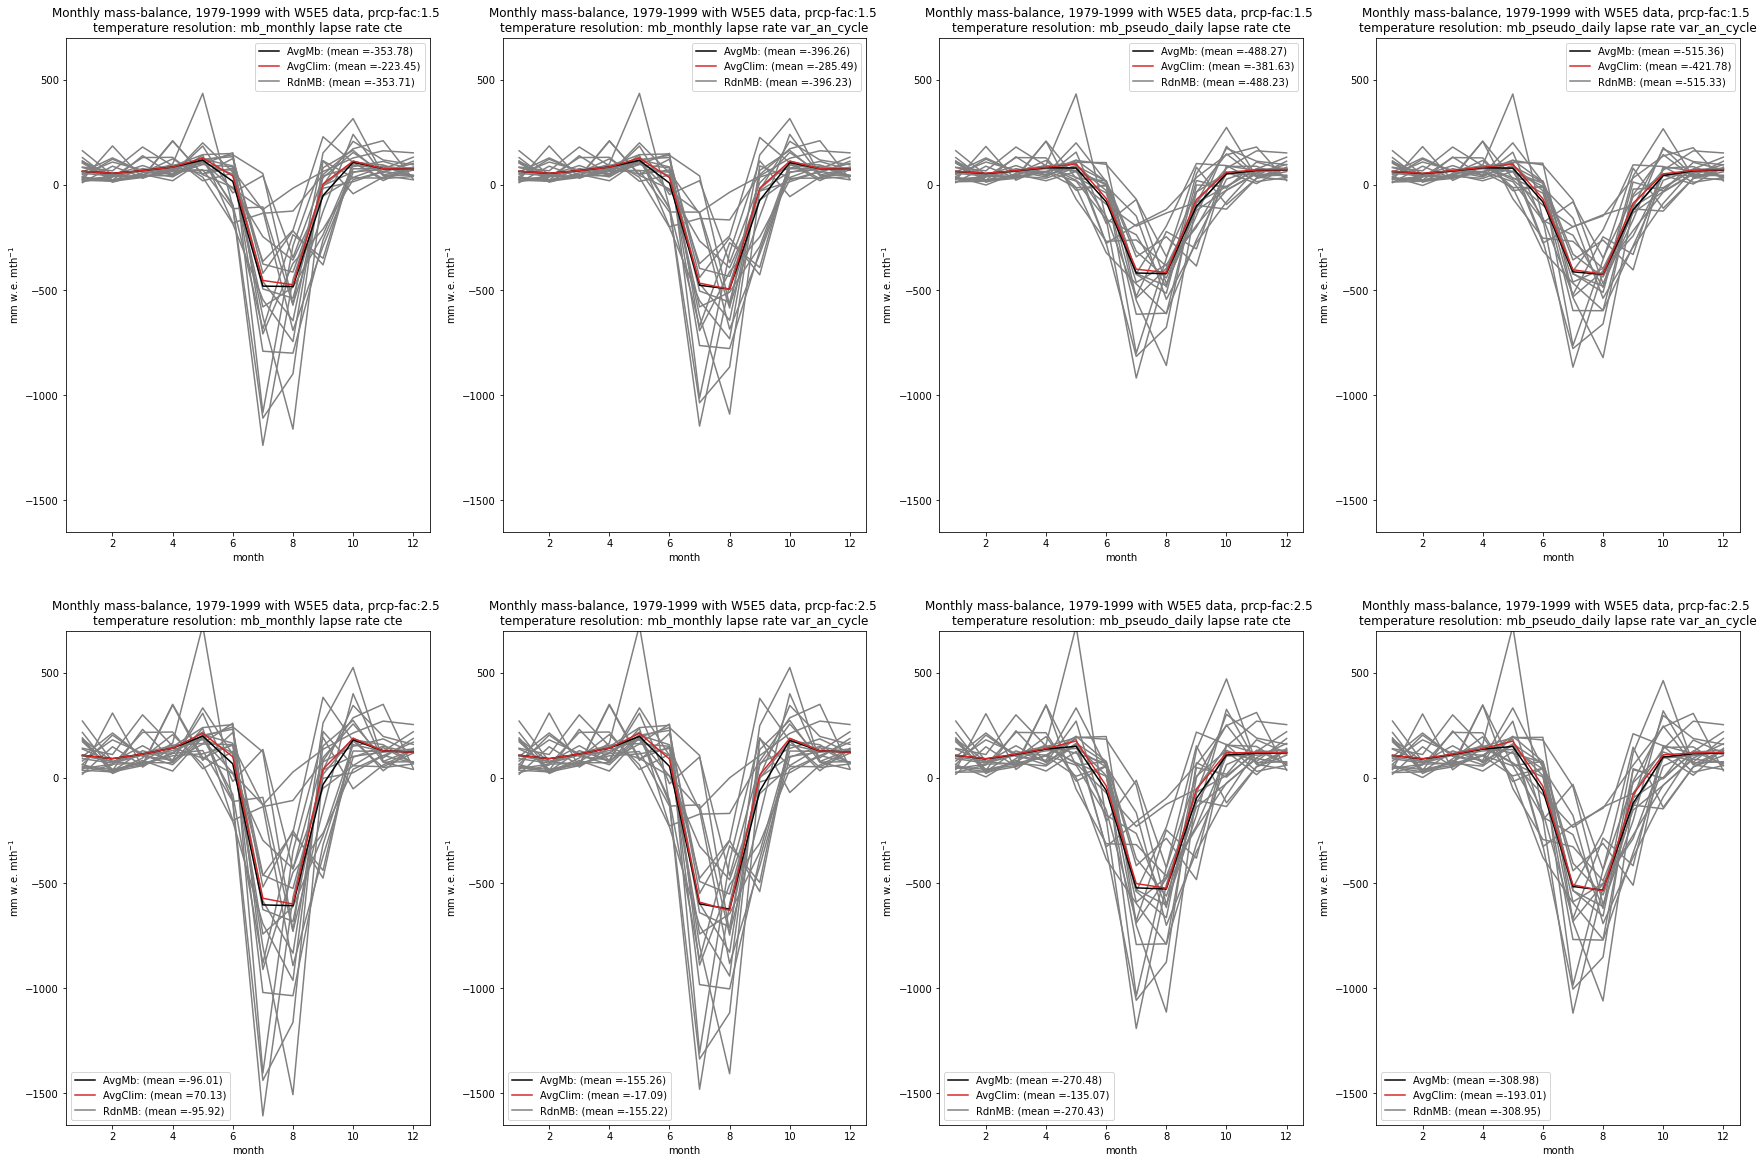

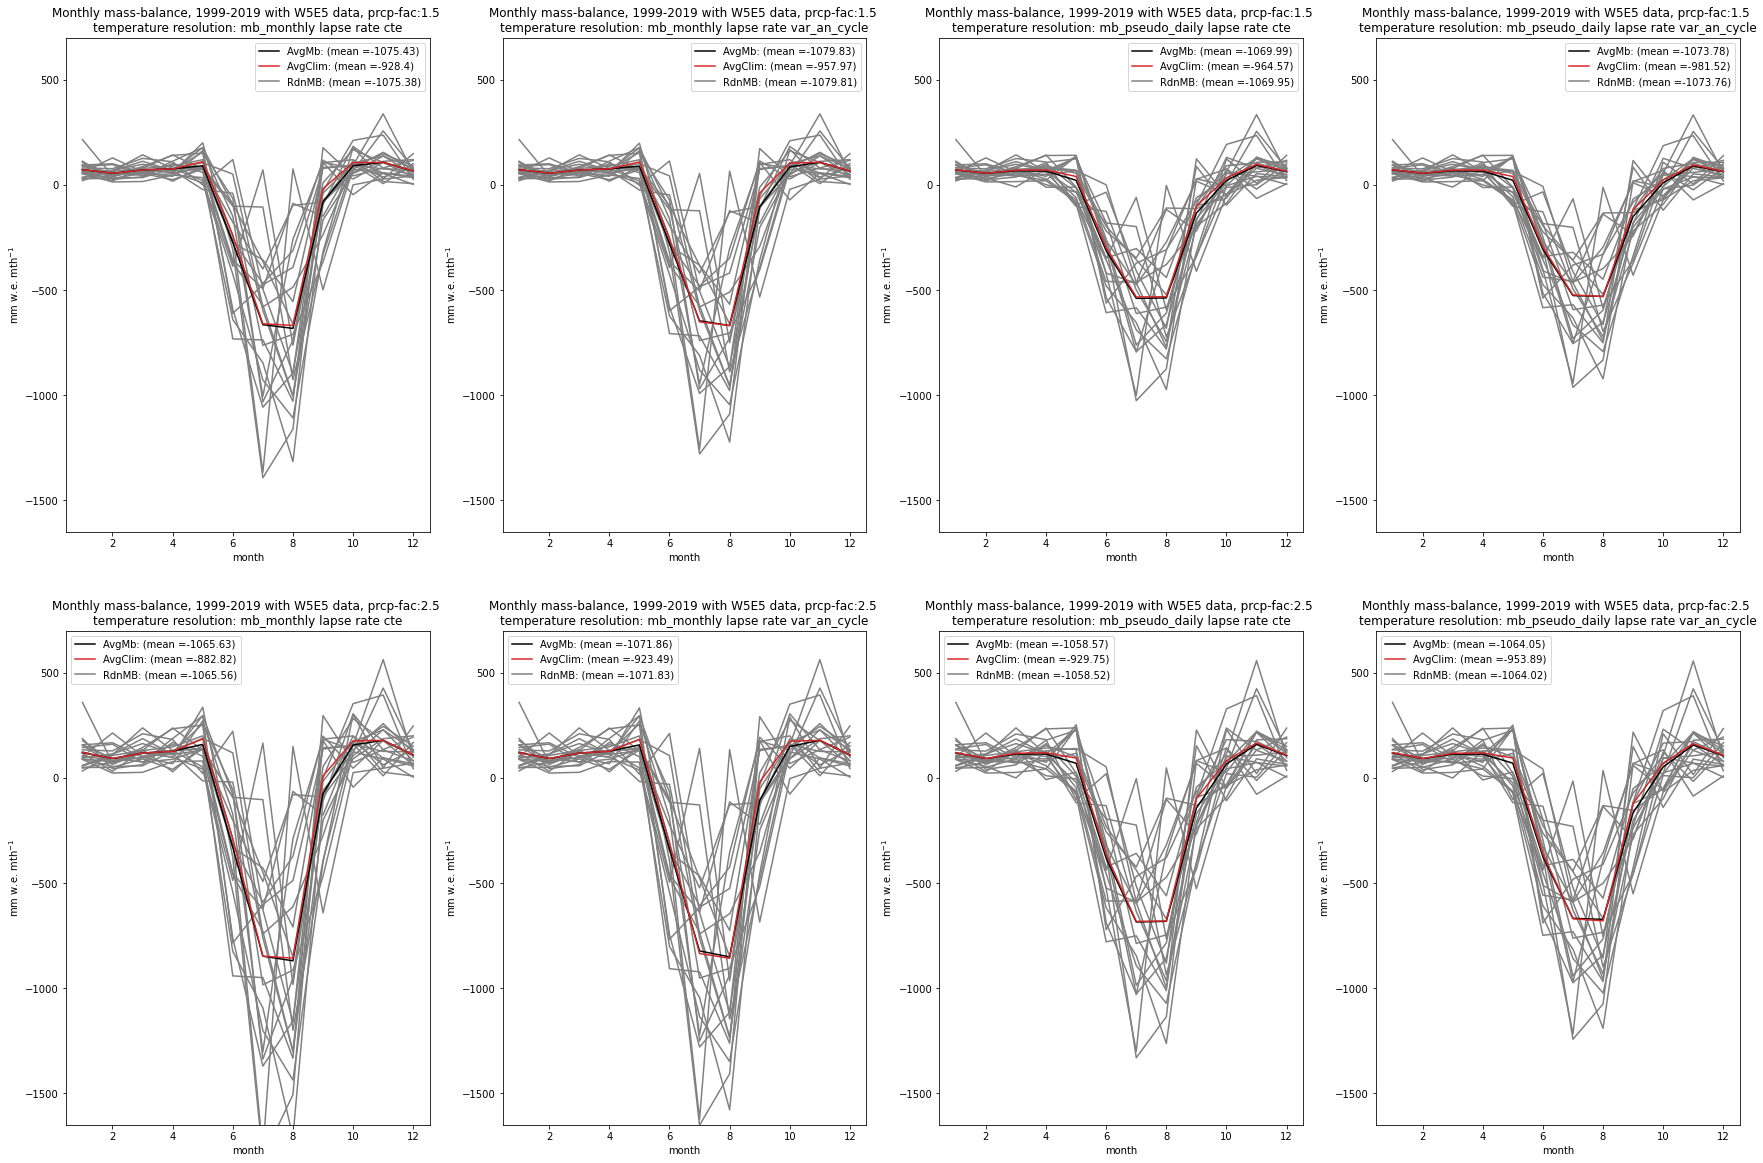

In [28]:
for y0 in [1989, 2009]:
    str1, str2 = str(y0-10), str(y0+10)
    plt.figure(figsize=(30,20))
    j=0
    for pf in ['1.5', '2.5']:
        for mb_type in ['mb_monthly', 'mb_pseudo_daily']:
            for grad_type in ['cte', 'var_an_cycle']:
                j +=1
                plt.subplot(2,4,j)
                ax =plt.gca()
                typ = f'{mb_type}_{grad_type}_pf_{pf}'

                df_past_x[typ][y0].plot(legend=False, c='grey', ax = ax);
                df_const_x[typ][y0][f'RdnMB: (mean ={df_past_x[typ][y0].mean(axis=1).sum().round(2)})'] = np.NaN
                df_const_x[typ][y0].plot(color=['k', 'C3', 'grey'], ax=ax);
                plt.xlabel('month')
                plt.title(f'Monthly mass-balance, {str1}-{str2} with W5E5 data, prcp-fac:{pf} \ntemperature resolution: {mb_type} lapse rate {grad_type}');
                plt.ylabel('mm w.e. mth$^{-1}$');
                plt.ylim([-1650, 700])
    plt.savefig(f'/home/lilianschuster/Schreibtisch/PhD/equilibrium_mb_sandbox/TIModel_monthly_mb_{str1}_{str2}_all.png', dpi=150, bbox_inches='tight')


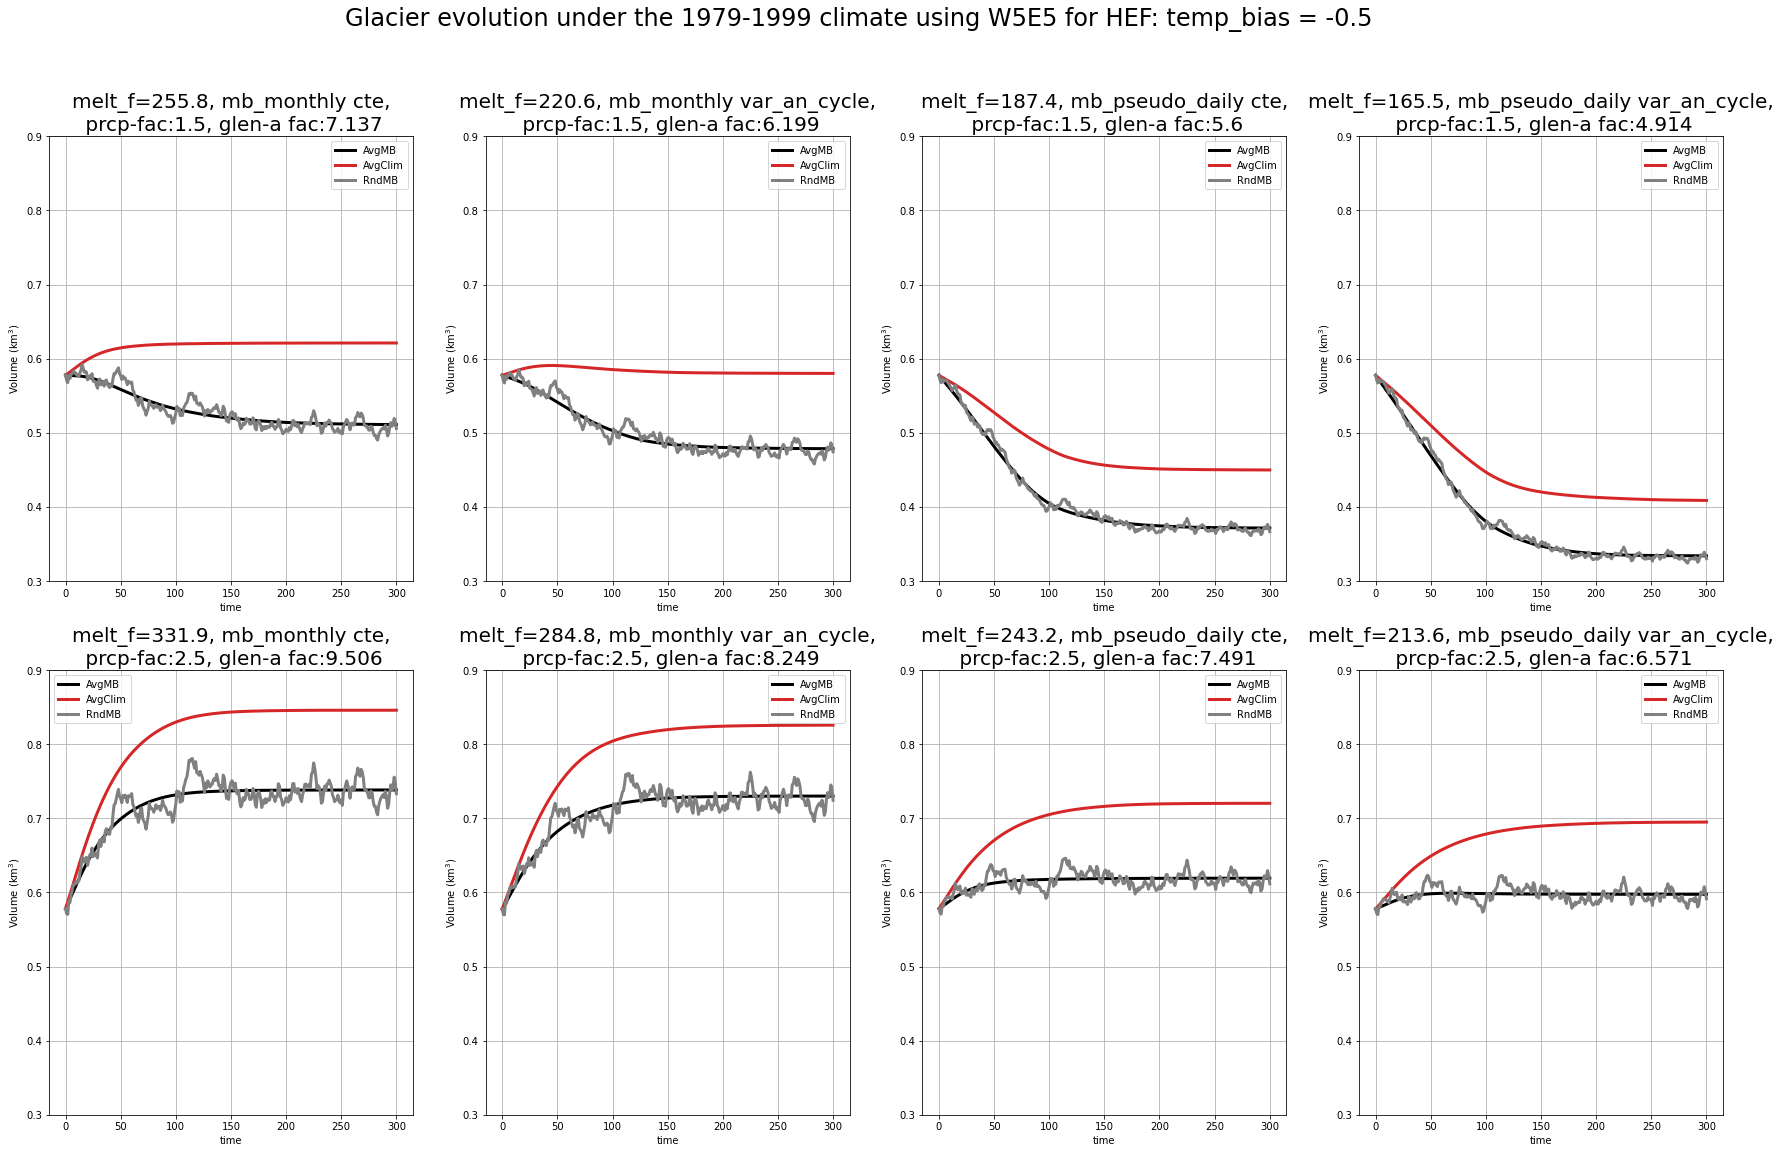

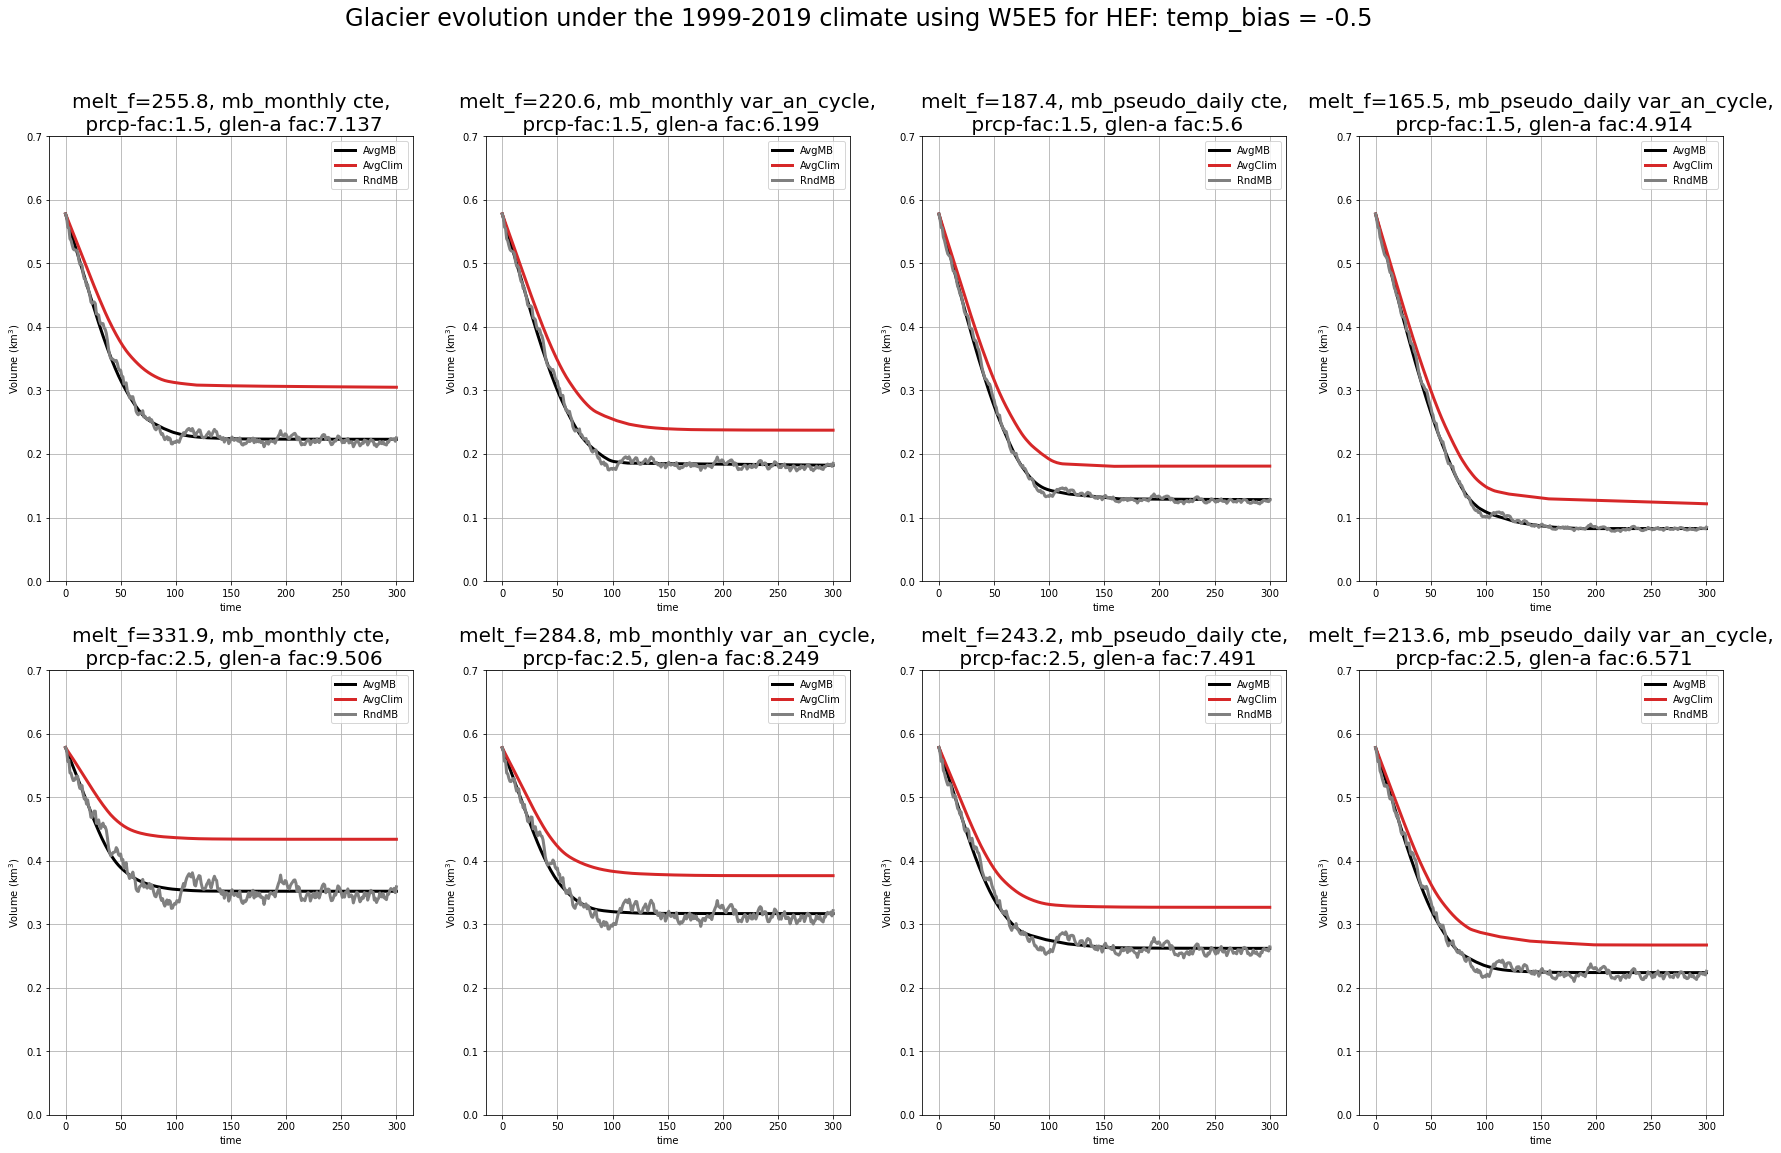

In [30]:
y0 = 1989
for y0 in [1989, 2009]:
    str1, str2 = str(y0-10), str(y0+10)
    plt.figure(figsize=(30,18))
    plt.suptitle(f'Glacier evolution under the {str1}-{str2} climate using W5E5 for HEF: temp_bias = {temp_bias}', fontsize=24)
    j=0
    for pf in ['1.5', '2.5']:
        for mb_type in ['mb_monthly', 'mb_pseudo_daily']:
            for grad_type in ['cte', 'var_an_cycle']:
                j +=1
                plt.subplot(2,4,j)
                ax =plt.gca()
                typ = f'{mb_type}_{grad_type}_pf_{pf}'
                (ds_const_x[typ][y0].volume * 1e-9).plot(c='k', label='AvgMB', lw=3);
                (ds_avg_x[typ][y0].volume * 1e-9).plot(c='C3', label='AvgClim', lw=3);
                (ds_rdn_x[typ][y0].volume * 1e-9).plot(c='grey', label='RndMB', lw=3);
                plt.legend();
                plt.ylim([0, 0.7])
                if temp_bias <0 and y0 ==1989:
                    plt.ylim([0.3, 0.9])

                plt.ylabel('Volume (km$^3$)');
                plt.title(f'melt_f={np.round(melt_f_calib_x[typ],1)}, {mb_type} {grad_type},\n prcp-fac:{pf}, glen-a fac:{out_fac_x[typ]}', fontsize=20)
                plt.grid()
    plt.savefig(f'/home/lilianschuster/Schreibtisch/PhD/equilibrium_mb_sandbox/TIModel_volume_{str1}_{str2}_all_temp_bias_{temp_bias}.png', dpi=150, bbox_inches='tight')

#plt.title(f'Glacier evolution under the {str1}-{str2} climate: melt_f={np.round(melt_f_calib,1)}\ntemperature resolution: {mb_type} using W5E5, \nprcp-fac:{pf}, glen-a fac:{out_fac}');


#plt.savefig(f'/home/lilianschuster/Schreibtisch/PhD/equilibrium_mb_sandbox/TIModel_volume_{str1}_{str2}_{mb_type}_W5E5_prcpfac{pf}_glenfac{out_fac}.png', dpi=150, bbox_inches='tight')

# OLD

Text(0.5, 15.0, 'month')

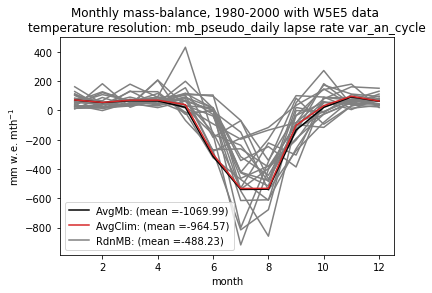

In [19]:
#df_past = df_past.sort_index()
ax = df_past.plot(legend=False, c='grey');
df_const[f'RdnMB: (mean ={df_past.mean(axis=1).sum().round(2)})'] = np.NaN
df_const.plot(color=['k', 'C3', 'grey'], ax=ax);
#plt.title(f'Glacier evolution under the {str1}-{str2} climate\ntemperature resolution: {mb_type}'); plt.ylabel('Volume (km$^3$)');
#plt.legend(labels=labels)
plt.title(f'Monthly mass-balance, {str1}-{str2} \ntemperature resolution: {mb_type} with W5E5 data'); plt.ylabel('mm w.e. mth$^{-1}$');
#plt.savefig(f'monthly_mb_{str2}.png', dpi=150, bbox_inches='tight')
plt.savefig(f'/home/lilianschuster/Schreibtisch/PhD/equilibrium_mb_sandbox/TIModel_monthly_mb_{str1}_{str2}_{mb_type}_W5E5_prcpfac{pf}.png', dpi=150, bbox_inches='tight')
plt.xlabel('month')

2021-08-11 16:51:43: MBsandbox.flowline_TIModel: (RGI60-11.00897) run_random_climate_TIModel_rdn
2021-08-11 16:51:43: oggm.core.flowline: (RGI60-11.00897) flowline_model_run_rdn
2021-08-11 16:51:46: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-08-11 16:51:46: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-08-11 16:51:46: MBsandbox.flowline_TIModel: (RGI60-11.00897) run_constant_climate_TIModel_const
2021-08-11 16:51:46: oggm.core.flowline: (RGI60-11.00897) flowline_model_run_const
2021-08-11 16:51:48: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-08-11 16:51:48: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-08-11 16:51:48: MBsandbox.flowline_TIModel: (RGI60-11.00897) run_constant_climate_TIModel_avg
2021-08-11 16:51:48: oggm.core.flowline: (RGI60-11.00897) flowline_model_run_avg
2021-08-11 16:51:51: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-08-11 16:51:51: oggm.utils: Applying compile_r

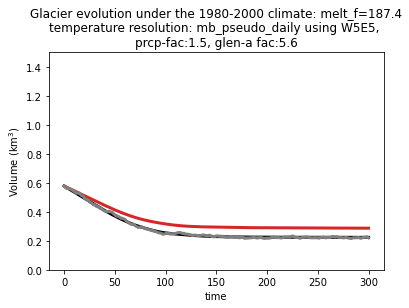

In [477]:
if y0 <1999:    
    temp_bias = 0
    run_random_climate_TIModel(gdir_sandbox, mb_type=mb_type, grad_type=grad_type, melt_f=melt_f_calib,
                           precipitation_factor=pf,
                           climate_input_filesuffix=climate_type,
                           #climate_input_filesuffix=climate_type_gcm, climate_filename='gcm_data',
                           nyears=300, y0=y0, halfsize=hs, output_filesuffix='_rdn',
                           unique_samples=True, seed=0, temperature_bias=temp_bias)
    ds_rdn = utils.compile_run_output([gdir_sandbox], input_filesuffix='_rdn')

    run_constant_climate_TIModel(gdir_sandbox, mb_type=mb_type, grad_type=grad_type,
                             melt_f=melt_f_calib, precipitation_factor=pf,
                             climate_input_filesuffix=climate_type,
                             #climate_input_filesuffix=climate_type_gcm, climate_filename='gcm_data',
                             bias = 0, 
                             nyears=300, y0=y0, halfsize=hs,
                             temperature_bias=temp_bias,
                             output_filesuffix='_const' )
    ds_const = utils.compile_run_output([gdir_sandbox], input_filesuffix='_const')

    run_constant_climate_TIModel(gdir_sandbox, mb_type=mb_type, grad_type=grad_type, melt_f=melt_f_calib, precipitation_factor=pf,
                           #climate_input_filesuffix=climate_type_gcm, climate_filename='gcm_data',
                             bias = 0, climate_input_filesuffix=climate_type,
                           nyears=300, y0=y0, halfsize=hs, use_avg_climate=True,
                             output_filesuffix='_avg', temperature_bias=temp_bias)
    ds_avg = utils.compile_run_output([gdir_sandbox], input_filesuffix='_avg')

    (ds_const.volume * 1e-9).plot(c='k', label='AvgMB', lw=3);
    (ds_avg.volume * 1e-9).plot(c='C3', label='AvgClim', lw=3);
    (ds_rdn.volume * 1e-9).plot(c='grey', label='RndMB', lw=3);
    plt.title(f'Glacier evolution under the {str1}-{str2} climate: melt_f={np.round(melt_f_calib,1)}\ntemperature resolution: {mb_type} using W5E5, \nprcp-fac:{pf}, glen-a fac:{out_fac}');

    if j == 0:
        plt.legend();
    plt.ylim([0, 1.5])
    plt.ylabel('Volume (km$^3$)');
    plt.savefig(f'/home/lilianschuster/Schreibtisch/PhD/equilibrium_mb_sandbox/TIModel_volume_{str1}_{str2}_{mb_type}_W5E5_prcpfac{pf}_glenfac{out_fac}.png', dpi=150, bbox_inches='tight')
else:
    plt.figure(figsize=(30,10))
    plt.suptitle(f'Glacier evolution under the {str1}-{str2} climate: melt_f={np.round(melt_f_calib,1)}\ntemperature resolution: {mb_type} using W5E5, prcp-fac:{pf}, glen-a fac:{out_fac}')
    #for j,temp_bias in enumerate([-1.5, -1, -0.5, 0, 0.5]):
    for j,temp_bias in enumerate([-1.5, -1, -0.5, 0, 0.5]):
        try:
            plt.subplot(1,5,j+1)


            run_random_climate_TIModel(gdir_sandbox, mb_type=mb_type, grad_type=grad_type, melt_f=melt_f_calib,
                                   precipitation_factor=pf,
                                   climate_input_filesuffix=climate_type,
                                   #climate_input_filesuffix=climate_type_gcm, climate_filename='gcm_data',
                                   nyears=300, y0=y0, halfsize=hs, output_filesuffix='_rdn',
                                   unique_samples=True, seed=0, temperature_bias=temp_bias)
            ds_rdn = utils.compile_run_output([gdir_sandbox], input_filesuffix='_rdn')

            run_constant_climate_TIModel(gdir_sandbox, mb_type=mb_type, grad_type=grad_type,
                                     melt_f=melt_f_calib, precipitation_factor=pf,
                                     climate_input_filesuffix=climate_type,
                                     #climate_input_filesuffix=climate_type_gcm, climate_filename='gcm_data',
                                     bias = 0, 
                                     nyears=300, y0=y0, halfsize=hs,
                                     temperature_bias=temp_bias,
                                     output_filesuffix='_const' )
            ds_const = utils.compile_run_output([gdir_sandbox], input_filesuffix='_const')

            run_constant_climate_TIModel(gdir_sandbox, mb_type=mb_type, grad_type=grad_type, melt_f=melt_f_calib, precipitation_factor=pf,
                                   #climate_input_filesuffix=climate_type_gcm, climate_filename='gcm_data',
                                     bias = 0, climate_input_filesuffix=climate_type,
                                   nyears=300, y0=y0, halfsize=hs, use_avg_climate=True,
                                     output_filesuffix='_avg', temperature_bias=temp_bias)
            ds_avg = utils.compile_run_output([gdir_sandbox], input_filesuffix='_avg')

            (ds_const.volume * 1e-9).plot(c='k', label='AvgMB', lw=3);
            (ds_avg.volume * 1e-9).plot(c='C3', label='AvgClim', lw=3);
            (ds_rdn.volume * 1e-9).plot(c='grey', label='RndMB', lw=3);
            plt.title(f'applied temp_bias:{temp_bias}');

            if j == 0:
                plt.legend();
            plt.ylim([0, 1.5])
            plt.ylabel('Volume (km$^3$)');
        except:
            pass
    plt.savefig(f'/home/lilianschuster/Schreibtisch/PhD/equilibrium_mb_sandbox/TIModel_volume_{str1}_{str2}_{mb_type}_W5E5_prcpfac{pf}_glenfac{out_fac}.png', dpi=150, bbox_inches='tight')


In [449]:
gdir_sandbox.get_ref_mb_data(input_filesuffix='_monthly_W5E5')['ANNUAL_BALANCE'].loc[2000:].mean()

-1146.0526315789473

# Trash

I also tried to use gcmdata instead, but somehow it did not grow ... even when using climate data from 1860...

In [ ]:


glen_a_calibrate = False
ensemble = 'mri-esm2-0_r1i1p1f1'
ssp = 'ssp126'
workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = ssp, temporal_resol =temporal_resol,
                                  climate_historical_filesuffix='_{}_{}'.format(temporal_resol, dataset) );


climate_type_gcm = '{}_{}_{}'.format('ISIMIP3b', ensemble, ssp)


import xarray as xr
gcm_data = xr.open_dataset(gdir_sandbox.get_filepath('gcm_data', filesuffix = f'_monthly_{climate_type_gcm}')).groupby('time.year').mean().sel(year=np.arange(1902,2020))

plt.plot(gcm_data.year, gcm_data.temp)

plt.plot(np.arange(1850,2020,1), mb_past.get_specific_mb(year=np.arange(1850,2020,1), heights = h))